In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')

from utils import *

In [3]:
sns.set(rc={'figure.figsize':(20,5)})

In [4]:
mbit_rate = 1/125000

low_fp = '../data/240p/' 
med_fp = '../data/480p/'
high_fp = '../data/1080p/' 

In [5]:
stdoan_low = pd.read_csv(low_fp + 'stdoan-101-action-240p-20201127.csv')
stdoan_med = pd.read_csv(med_fp + 'stdoan-101-action-480p-20201127.csv')
stdoan_high = pd.read_csv(high_fp + 'stdoan-101-action-1080p-20201127.csv')

In [6]:
## loading in multiple data sets; primarily to compare and contrast the difference betweena action and still later on
iman_low = pd.read_csv(low_fp + 'imnemato-104-action-240p-20210110.csv') ## wrong ip
iman_med = pd.read_csv(med_fp + 'imnemato-104-action-480p-20210110.csv') ## wrong ip
iman_high = pd.read_csv(high_fp + 'imnemato-104-action-1080p-20210110.csv') ## wrong ip

imm_low = filter_ip(iman_low)
imm_med = filter_ip(iman_med)
imm_high = filter_ip(iman_high)

andrew_low = pd.read_csv(low_fp+'sgs008-107-still-240p-20210112.csv')
andrew_med = pd.read_csv(med_fp+'sgs008-107-still-480p-20210112.csv')
andrew_high = pd.read_csv(high_fp+'sgs008-107-still-1080p-20210112.csv')

sgs_low = filter_ip(andrew_low)
sgs_med = filter_ip(andrew_med)
sgs_high = filter_ip(andrew_high)

shrimant_low = pd.read_csv(low_fp + 'shs214-108-action-240p-20210112.csv')
shrimant_med = pd.read_csv(med_fp + 'shs214-108-action-480p-20210112.csv')
shrimant_high = pd.read_csv(high_fp + 'shs214-108-action-1080p-20210112.csv')

# shrimant_low = pd.read_csv(low_fp + 'shs214-103-still-240p-20210109.csv')
# shrimant_med = pd.read_csv(med_fp + 'shs214-103-still-480p-20210109.csv')
# shrimant_high = pd.read_csv(high_fp + 'shs214-103-still-1080p-20210109.csv')

shs_low = filter_ip(shrimant_low)
shs_med = filter_ip(shrimant_med)
shs_high = filter_ip(shrimant_high)

## Aggregate Features

In [7]:
## take the average of the whole chunk; download and upload
def avg_bytes(df, col):
  return np.mean(df[col])

## take the std of whole chunk; download and upload
def std_bytes(df, col):
  return np.std(df[col])

## take the ratio of upload:download packets
def pkt_ratio(df):
  ms_df = convert_ms_df(df, True)
  local = np.sum(ms_df['pkt_src'] == '1') 
  server = np.sum(ms_df['pkt_src'] == '2') 
  return local / server

## take the ratio of upload:download bytes
def bytes_ratio(df):
  local = df['1->2Bytes'].sum()
  server = df['2->1Bytes'].sum()
  return local / server

## Peak Related Aggregate Features

In [58]:
## finds the peaks with mean + 2(1) std
## run the above aggregate functions on the peaks only??

def get_peak_loc(df, col, invert=False):
  'invert arg allows you to get values not considered peaks'
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg #+ (1 * df_std)
  
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)

def peak_time_diff(df, col='2->1Bytes', func=np.std):
  peaks = df[get_peak_loc(df, col)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'])
  return func(time_diff)

In [21]:
def chunk_data_temp(df, interval=100):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [59]:
andrew_low = pd.read_csv(low_fp+'sgs008-107-still-240p-20210112.csv')
andrew_med = pd.read_csv(med_fp+'sgs008-107-still-480p-20210112.csv')
andrew_high = pd.read_csv(high_fp+'sgs008-107-still-1080p-20210112.csv')

In [ ]:
low_peaks = andrew_low[get_peak_loc(andrew_low, '2->1Bytes')]
plt.plot()

In [21]:
low_ms = convert_ms_df(stdoan_low, True)
med_ms = convert_ms_df(stdoan_med, True)
high_ms = convert_ms_df(stdoan_high, True)

In [50]:
%%time
low_chunks = chunk_data_temp(andrew_low)
med_chunks = chunk_data_temp(andrew_med)
high_chunks = chunk_data_temp(andrew_high)

Wall time: 76.3 ms


In [35]:
low_chunks = chunk_data_temp(stdoan_low)
med_chunks = chunk_data_temp(stdoan_med)
high_chunks = chunk_data_temp(stdoan_high)

In [47]:
andrew_grp = andrew_low.groupby('Time')[['2->1Bytes']].sum().reset_index()

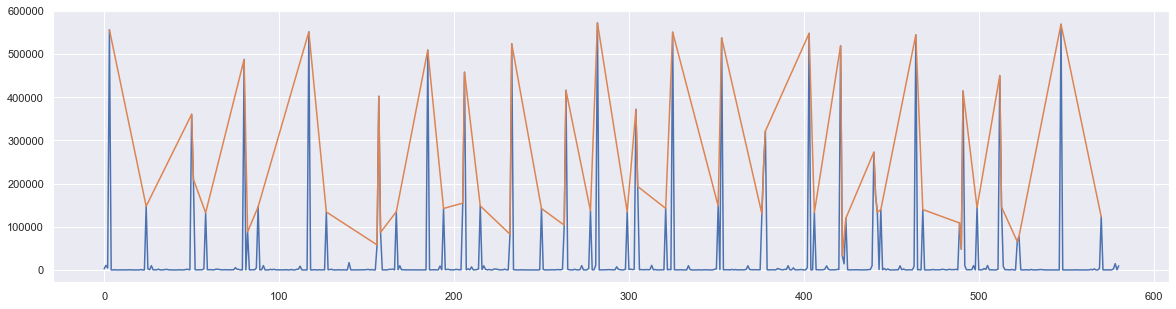

In [67]:

low_peaks = andrew_low[get_peak_loc(andrew_low, '2->1Bytes')]
plt.plot(andrew_low['2->1Bytes'])
plt.plot(low_peaks['2->1Bytes'])

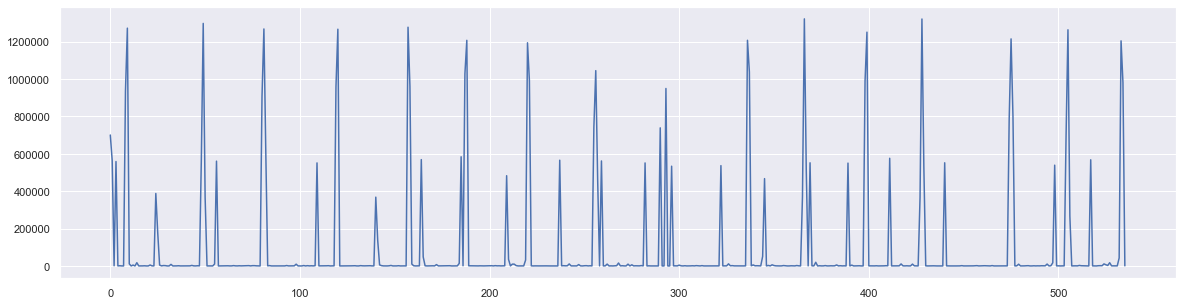

In [68]:
plt.plot(andrew_high['2->1Bytes'])

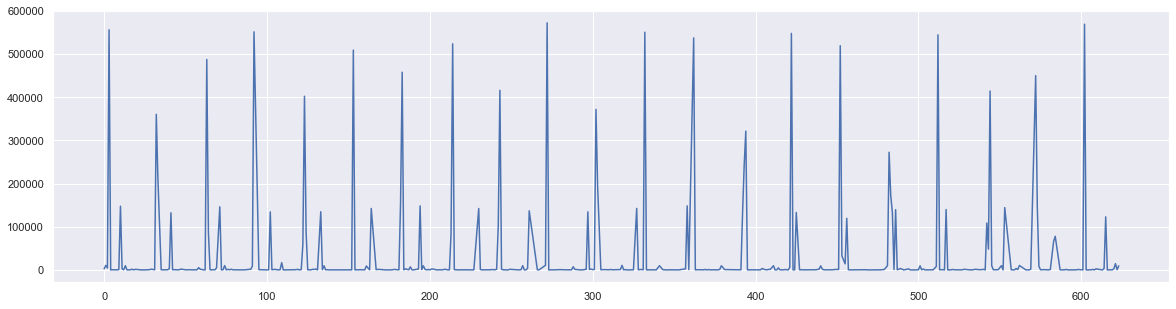

In [34]:
plt.plot(andrew_grp)

In [54]:
def peak_time_diff(df, col='2->1Bytes', func=np.std):
  peaks = df[get_peak_loc(df, col)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'])
  return func(time_diff)

In [55]:
for temp_df in low_chunks:
  print(peak_time_diff(temp_df))

8.066053836281773
6.534055214873869
4.841487374764082
12.229105462304398
12.657891697365018
9.516301802696255


In [56]:
for temp_df in med_chunks:
  print(peak_time_diff(temp_df))

10.893423092245461
8.845614617378699
8.888194417315589
11.710800875382398
11.199489784296937
12.753038853543888


In [57]:
for temp_df in high_chunks:
  print(peak_time_diff(temp_df))

13.078226179417452
8.214147686901072
9.945530666933443
10.582267006648433
10.71714247629203
11.6880013261464


In [10]:
low_resample = low_ms.resample('500ms', on='Time').sum()
med_resample = med_ms.resample('500ms', on='Time').sum()
high_resample = high_ms.resample('500ms', on='Time').sum()

# places = get_peaks(high_resample, 'pkt_size')
# filtered_low = filter_noise(high_resample, 'pkt_size')

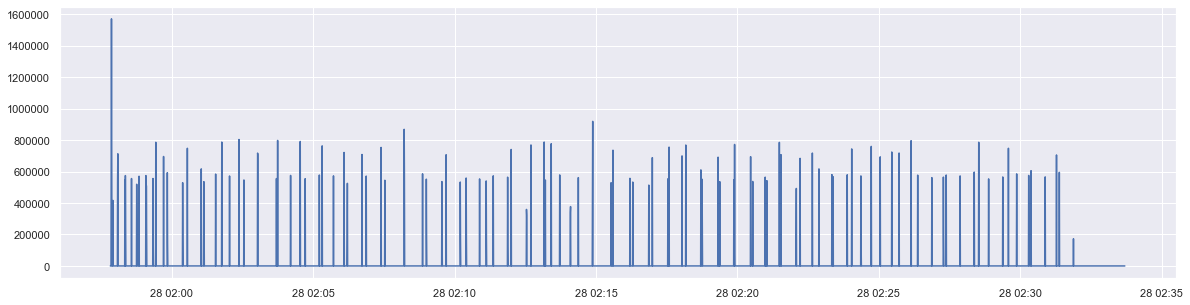

In [332]:
#peak_low_rs = get_peaks(low_resample, 'pkt_size')
plt.plot(filtered_low)

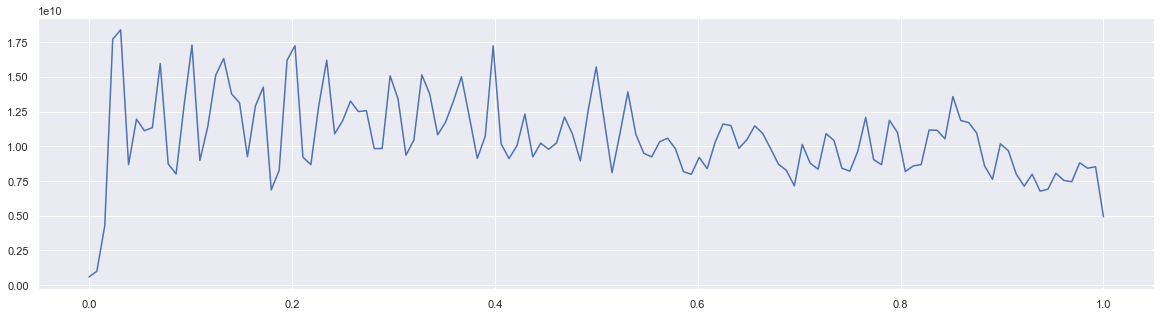

In [333]:
f_filter, Pxx_filter = sp.signal.welch(filtered_low['pkt_size'], fs=2)
plt.plot(f_filter, Pxx_filter)

## Spectral Features


In [247]:
low_ms = convert_ms_df(stdoan_low, True)
med_ms = convert_ms_df(stdoan_med, True)
high_ms = convert_ms_df(stdoan_high, True)

In [267]:
low_resample = low_ms.resample('500ms', on='Time').sum()
med_resample = med_ms.resample('500ms', on='Time').sum()
high_resample = high_ms.resample('500ms', on='Time').sum()

f_low, Pxx_low = sp.signal.welch(low_resample['pkt_size'])
f_med, Pxx_med = sp.signal.welch(med_resample['pkt_size'])
f_high, Pxx_high = sp.signal.welch(high_resample['pkt_size'])

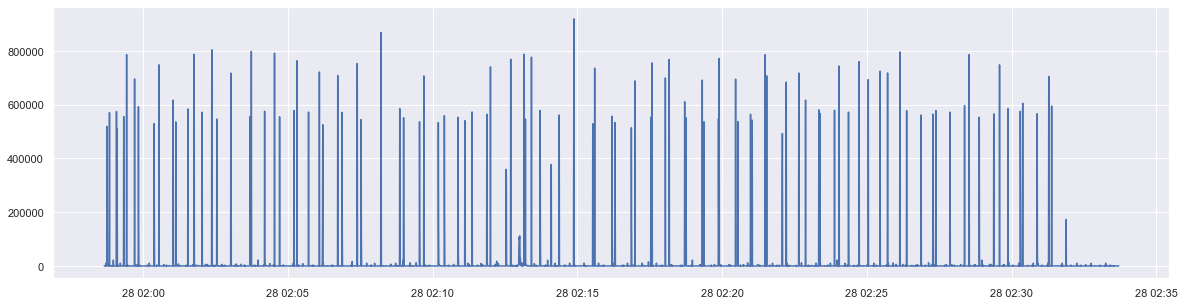

In [268]:
plt.plot(low_resample['pkt_size'][100:])

In [269]:
f_test, Pxx_test = sp.signal.welch(low_resample['pkt_size'][100:], fs=2)

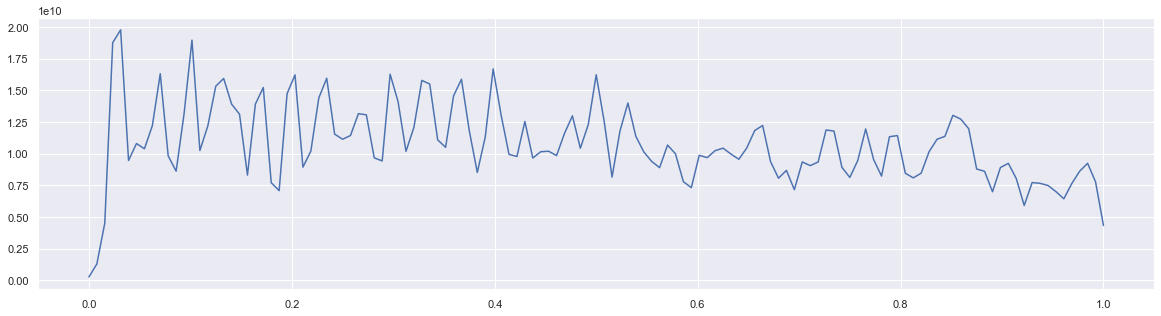

In [270]:
plt.plot(f_test, Pxx_test)

In [271]:
sp.signal.find_peaks(Pxx_test)#[0]

(array([  4,   6,   9,  13,  17,  22,  26,  30,  34,  38,  42,  47,  51,
         55,  58,  61,  64,  68,  73,  77,  80,  85,  88,  90,  93,  98,
        102, 109, 116, 119, 126], dtype=int64), {})

In [272]:
(Pxx_test).argmax()

4

In [273]:
f_test[4]

0.03125

In [ ]:
def spectral_features(df, col):

    """
    welch implemention of spectral features
    """

    f, Pxx_den = sp.signal.welch(df[col], fs=2)
    Pxx_den = np.sqrt(Pxx_den)

    peaks = sp.signal.find_peaks(Pxx_den)[0]
    prominences = sp.signal.peak_prominences(Pxx_den, peaks)[0]

    idx_max = prominences.argmax()
    loc_max = peaks[idx_max]

    return [f[loc_max], Pxx_den[loc_max], prominences[idx_max]]

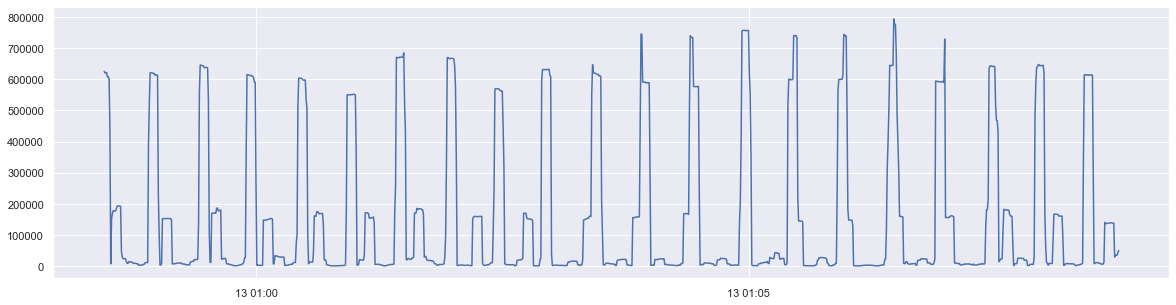

In [229]:
plt.plot(low_resample.rolling(12).sum())

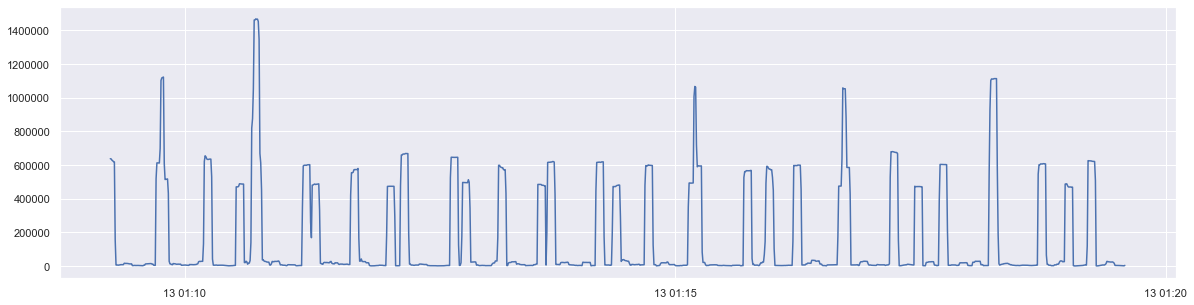

In [209]:
plt.plot(med_resample.rolling(10).sum())

In [227]:
f_roll, Pxx_roll = sp.signal.welch(med_resample.rolling(12).sum()[12:]['pkt_size'], fs=2)

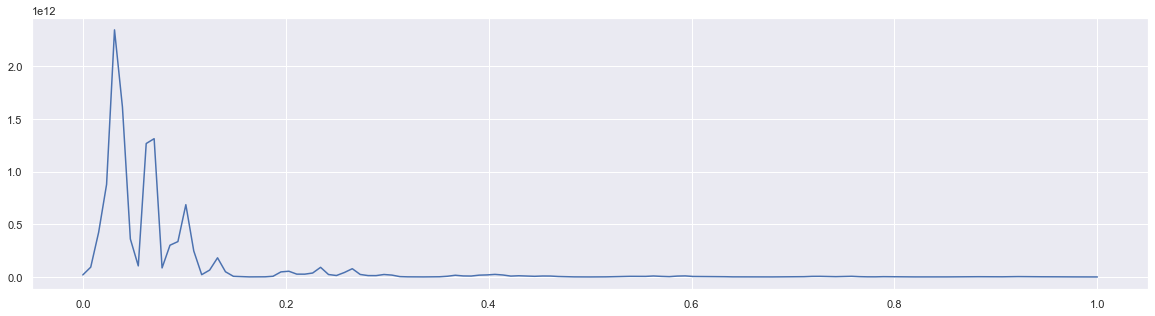

In [228]:
plt.plot(f_roll, Pxx_roll)

In [237]:
low_ms = convert_ms_df(stdoan_low, True)
med_ms = convert_ms_df(stdoan_med, True)
high_ms = convert_ms_df(stdoan_high, True)

In [242]:
low_resample = low_ms.resample('5s', on='Time').sum()
med_resample = med_ms.resample('5s', on='Time').sum()
high_resample = high_ms.resample('5s', on='Time').sum()

f_low, Pxx_low = sp.signal.welch(low_resample['pkt_size'], fs=.2)
f_med, Pxx_med = sp.signal.welch(med_resample['pkt_size'], fs=.2)
f_high, Pxx_high = sp.signal.welch(high_resample['pkt_size'], fs=.2)

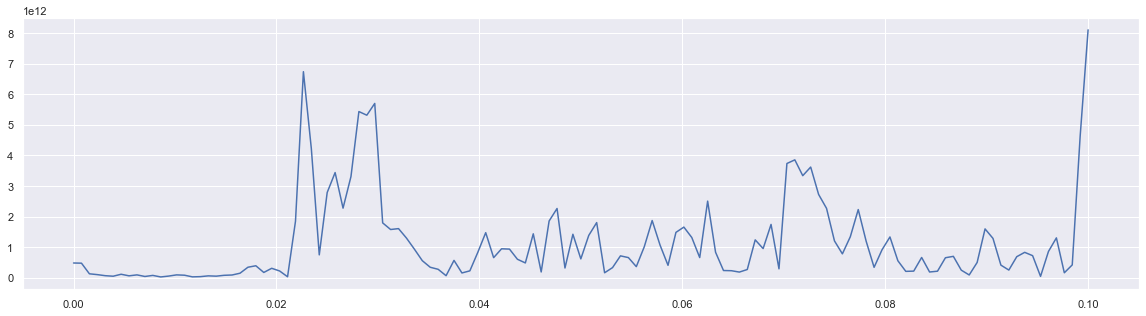

In [243]:
plt.plot(f_low, Pxx_low)

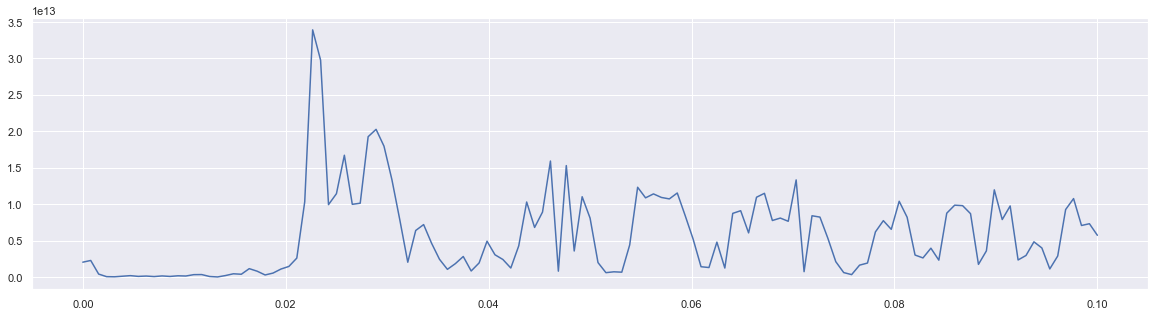

In [244]:
plt.plot(f_med, Pxx_med)

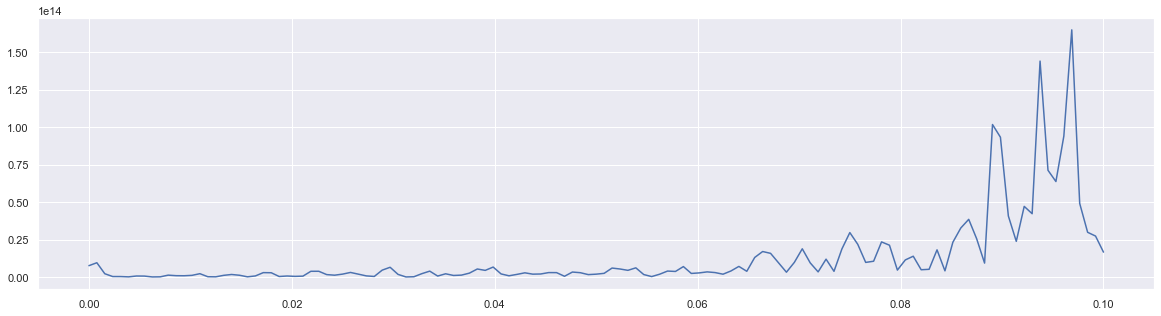

In [245]:
plt.plot(f_high, Pxx_high)

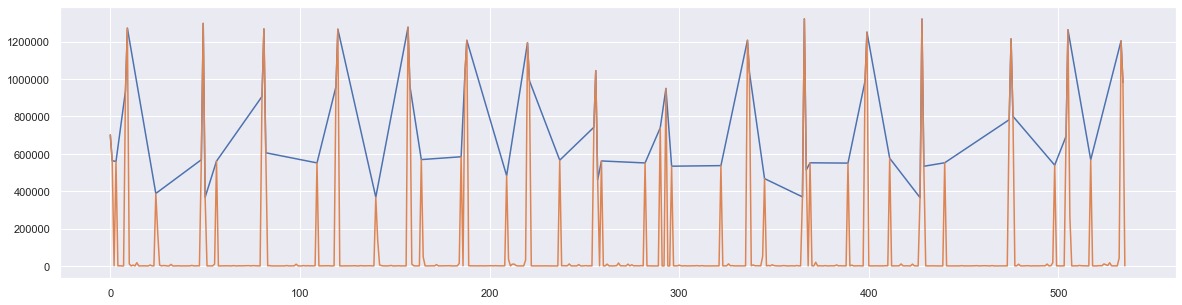

In [175]:
plt.plot(get_peaks(andrew_high, '2->1Bytes')['2->1Bytes'])
plt.plot(andrew_high['2->1Bytes'])

In [120]:
test_roll = convert_ms_df(stdoan_low, False)

In [109]:
temp = test_roll.resample('500ms', on='Time').sum().rolling(5).mean()

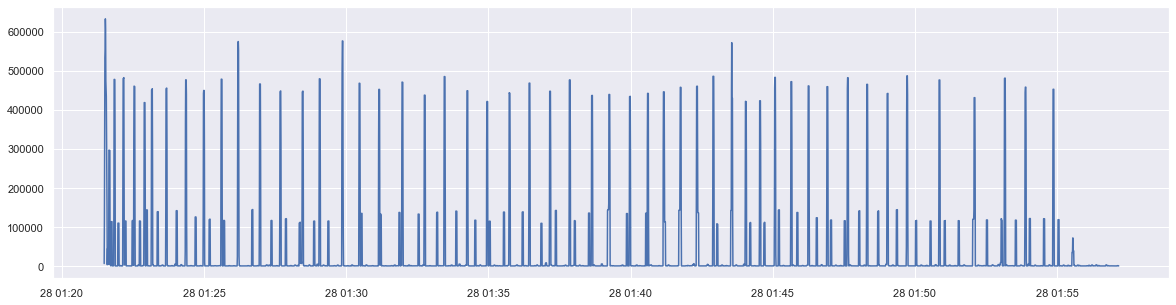

In [110]:
plt.plot(temp)

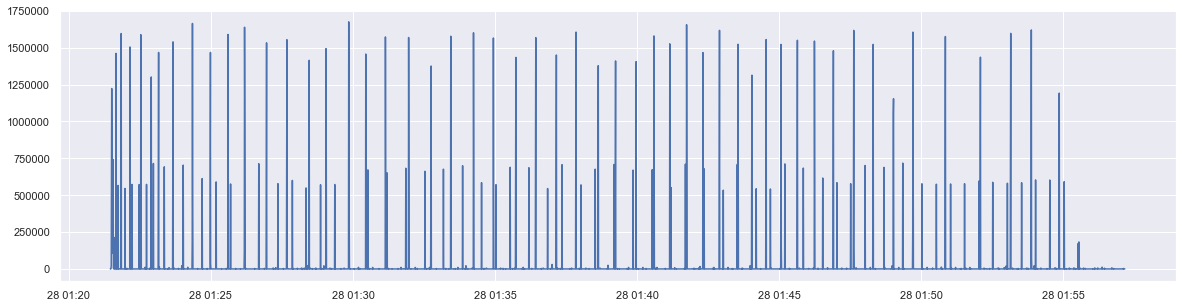

In [111]:
plt.plot(test_roll.resample('500ms', on='Time').sum())